In [1]:
import joblib

X_train, y_train, X_test, y_test = joblib.load('/kaggle/input/ber-train-test-data-pkl-zip/bert_train_test_data.pkl')

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts

import requests, zipfile, os
import io
import gc
import psutil

import nltk

In [3]:
# Define the (UNI)LSTM model with additional dense layers
max_sequence_length, embedding_dim = 128, 768
model = Sequential()
model.add(LSTM(128, input_shape=(max_sequence_length, embedding_dim), return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

num_classes = len(np.unique(y_train))
model.add(Dense(num_classes, activation='softmax'))

# Define the (BI)LSTM model with additional dense layers
bi_model = Sequential()
bi_model.add(LSTM(128, input_shape=(max_sequence_length, embedding_dim), return_sequences=False))
bi_model.add(Dropout(0.2))

bi_model.add(Dense(64, activation='relu'))
bi_model.add(Dropout(0.2))

bi_model.add(Dense(32, activation='relu'))
bi_model.add(Dropout(0.2))

bi_model.add(Dense(num_classes, activation='softmax'))

# Define cosine annealing learning rate schedule
cosine_annealing = CosineDecayRestarts(
    initial_learning_rate=0.0005,
    first_decay_steps=20,
    t_mul=2,
    alpha=0.01
)

# Compile the model using this schedule
optimizer = Adam(learning_rate=cosine_annealing)
bi_optimizer = Adam(learning_rate=cosine_annealing)

# Compile the model using the custom learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_model.compile(optimizer=bi_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',     # Monitor the validation loss
    patience=20,             # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore the weights of the best epoch if no improvement
)

# Summary of the model
model.summary()
bi_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       459,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 470,260 (1.79 MB)

 Trainable params: 470,260 (1.79 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │       459,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 470,260 (1.79 MB)

 Trainable params: 470,260 (1.79 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=200,                      # Maximum number of epochs
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],      # Add early stopping callback
    verbose=1
)

# Train the bi_model with early stopping
bi_history = bi_model.fit(
    X_train, y_train,
    epochs=200,                      # Maximum number of epochs
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],      # Add early stopping callback
    verbose=1
)

Epoch 1/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.1160 - loss: 2.8112 - val_accuracy: 0.4077 - val_loss: 1.8952
Epoch 2/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.3434 - loss: 2.0187 - val_accuracy: 0.4878 - val_loss: 1.5787
Epoch 3/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.4600 - loss: 1.6631 - val_accuracy: 0.4955 - val_loss: 1.5161
Epoch 4/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5000 - loss: 1.5301 - val_accuracy: 0.5536 - val_loss: 1.3218
Epoch 5/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5622 - loss: 1.3293 - val_accuracy: 0.5817 - val_loss: 1.2623
Epoch 6/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5804 - loss: 1.2757 - val_accuracy: 0.5841 - val_loss: 1.2662
Epoch 7/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5931 - loss: 1.2377 - val_accuracy: 0.6194 - val_loss: 1.2091
Epoch 8/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6267 - loss: 1.1546 -

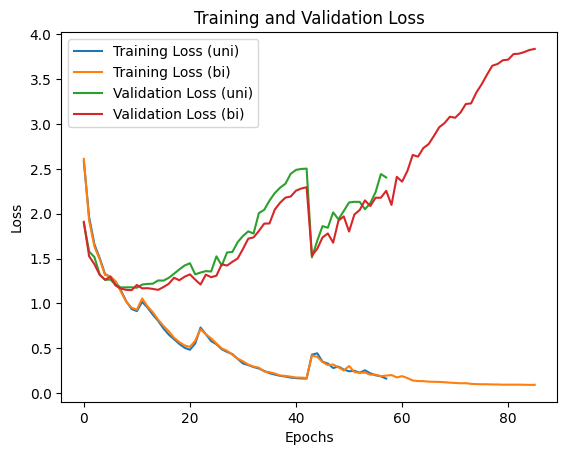

In [5]:
# Extract and store the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

bi_train_loss = bi_history.history['loss']
bi_val_loss = bi_history.history['val_loss']
bi_train_accuracy = bi_history.history['accuracy']
bi_val_accuracy = bi_history.history['val_accuracy']

plt.plot(train_loss, label='Training Loss (uni)')
plt.plot(bi_train_loss, label='Training Loss (bi)')
plt.plot(val_loss, label='Validation Loss (uni)')
plt.plot(bi_val_loss, label='Validation Loss (bi)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

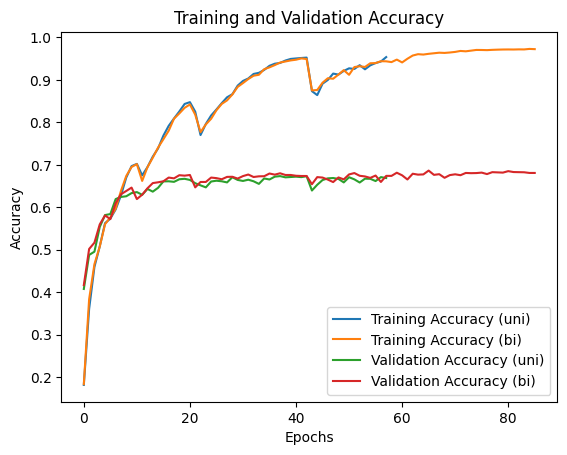

In [6]:
plt.plot(train_accuracy, label='Training Accuracy (uni)')
plt.plot(bi_train_accuracy, label='Training Accuracy (bi)')
plt.plot(val_accuracy, label='Validation Accuracy (uni)')
plt.plot(bi_val_accuracy, label='Validation Accuracy (bi)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [7]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
bi_test_loss, bi_test_accuracy = bi_model.evaluate(X_test, y_test)
print(f"Test Loss (uni): {test_loss}")
print(f"Test Accuracy (uni): {test_accuracy}")
print(f"Test Loss (bi): {bi_test_loss}")
print(f"Test Accuracy (bi): {bi_test_accuracy}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6707 - loss: 2.4059
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6809 - loss: 2.9329
Test Loss (uni): 2.2905478477478027
Test Accuracy (uni): 0.6734747886657715
Test Loss (bi): 2.776675224304199
Test Accuracy (bi): 0.6864721775054932
